In [1]:
from __future__ import division
import matplotlib
from pylab import *
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import linregress
from scipy.signal import argrelextrema
import numpy as np
import pandas as pd
import math
from ddeint import ddeint
import copy

In [2]:
from lmfit import minimize, Parameters, Parameter, report_fit
from scipy.integrate import odeint

In [3]:
# Define some plotting styles that we will use.
fontSize=15
matplotlib.rcParams.update({"axes.formatter.limits": (-4,4),'font.family':'Avenir','font.size': fontSize, "axes.titlesize": fontSize, "xtick.labelsize": fontSize, "ytick.labelsize": fontSize,})
plotStyles={"markersize":12,"markeredgewidth":2.0,"linewidth":2.0}
stepStyles={"markersize":15,"markeredgewidth":3.0,"linewidth":4.0,"where":"post"}
scatterStyles={"linewidth":1.0}

# 1 Load data

In [4]:
df=pd.read_csv('../data/TECAN_230114.csv',delimiter=',',index_col=0)  
#time = df.to_numpy()[0]/60

In [5]:
ydata1 = df.loc['E7'].to_numpy()
ydata2 = df.loc['E8'].to_numpy()
ydata3 = df.loc['F7'].to_numpy()
ydata4 = df.loc['F8'].to_numpy()

ymean = (ydata1+ydata2+ydata3)/3; 


In [6]:
from matplotlib.pyplot import cm
colors=cm.turbo.reversed()(np.linspace(0,1,10))
colors

array([[0.4796 , 0.01583, 0.01055, 1.     ],
       [0.79125, 0.16368, 0.01387, 1.     ],
       [0.96187, 0.41093, 0.0931 , 1.     ],
       [0.98   , 0.73   , 0.22161, 1.     ],
       [0.78563, 0.93579, 0.20336, 1.     ],
       [0.44321, 0.99551, 0.37345, 1.     ],
       [0.10342, 0.896  , 0.715  , 1.     ],
       [0.21382, 0.65886, 0.97959, 1.     ],
       [0.27334, 0.38008, 0.84037, 1.     ],
       [0.18995, 0.07176, 0.23217, 1.     ]])

In [7]:
my_dict = {'1e10':['A1','A2','B1','B2'],
          '1e9':['A3','A4','B3','B4'],
          '1e8':['A5','A6','B5','B6'],
          '1e7':['A7','A8','B7','B8'],
          '1e6':['C1','C2','D1','D2'],
          '1e5':['C3','C4','D3','D4'],
          '1e4':['C5','C6','D5','D6'],
          '1e3':['C7','C8','D7','D8'],
          '1e2':['E1','E2','F1','F2'],
          '1e1':['E3','E4','F3','F4']}
labels = list(my_dict.keys())

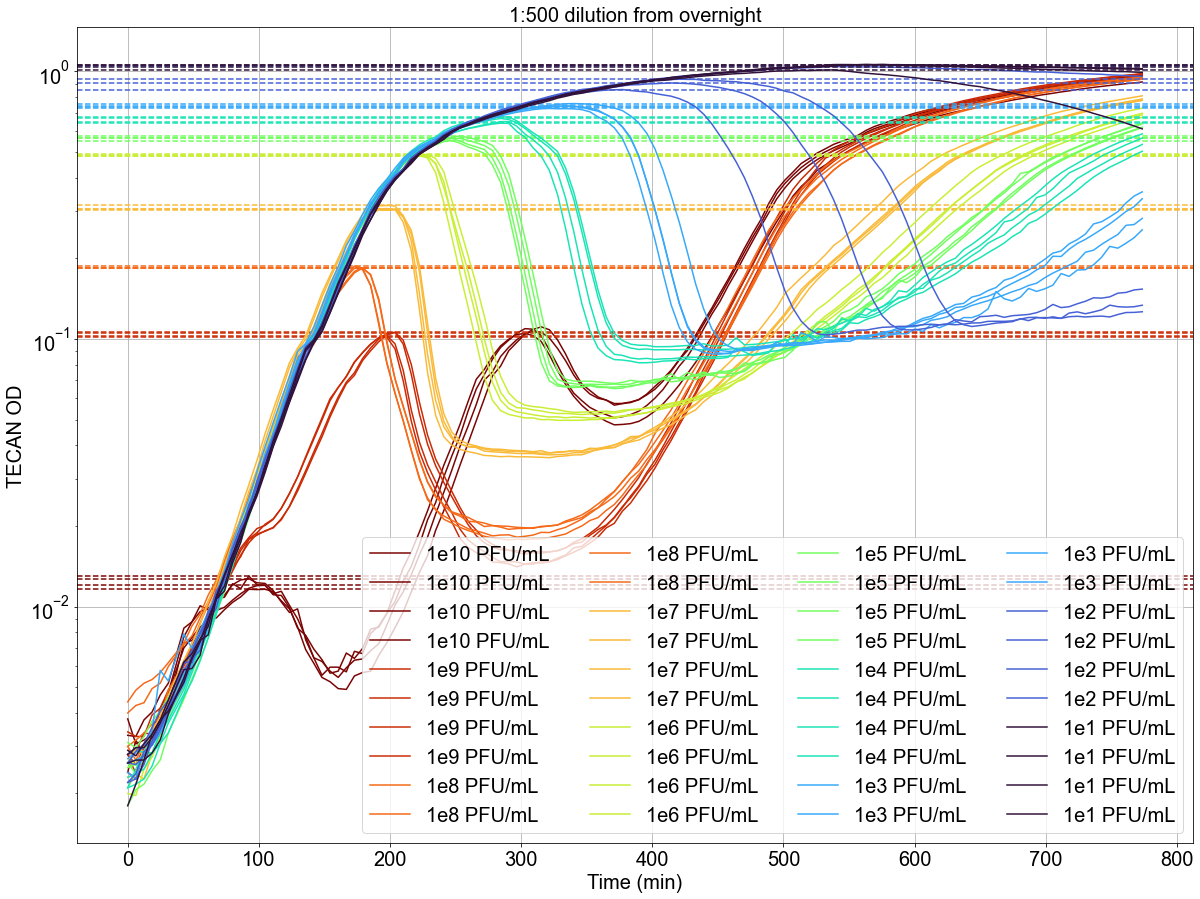

In [8]:
OD_01 = {};
time_01= {}; 
idx_01 = {};

k = 0; 
i = 10; 
fontSize=20
matplotlib.rcParams.update({"axes.formatter.limits": (-4,4),'font.family':'Arial','font.size': fontSize, "axes.titlesize": fontSize, "xtick.labelsize": fontSize, "ytick.labelsize": fontSize,})
matplotlib.rcParams.update({"figure.figsize": (20,15)})
for label_ in labels:
    OD = np.array([]);
    time_ = np.array([]);
    indx_ = np.array([]); 
    for j in my_dict[label_]:
        x_ = df.to_numpy()[0]/60
        y_ = df.loc[j].to_numpy() - ymean
        if i < 8:
            y_tmp = y_[x_>150]; 
            idx = argrelextrema(y_tmp, np.greater_equal)[0][0];
        else:
            y_tmp = y_[x_>80]; 
            idx = argrelextrema(y_tmp, np.greater_equal)[0][0];
        idx = idx + len(y_) - len(y_tmp);
        plt.plot(x_, y_, color = colors[k,:], label='1e'+str(i)+' PFU/mL')
        plt.axhline(y_[idx], color = colors[k,:], linestyle = '--')
        OD = np.append(OD, y_[idx]);
        time_ = np.append(time_, x_[idx]);
        indx_ = np.append(indx_, idx);
    OD_01[i] = OD; 
    time_01[i] = time_;
    idx_01[i] = indx_; 
    k = k+1; 
    i = i-1;
plt.title('1:500 dilution from overnight')
plt.xlabel('Time (min)')
plt.ylabel('TECAN OD')
plt.yscale('log')
plt.grid(True)
plt.legend(ncol=4)

# 2 Calibration curve

In [9]:
colors=cm.rainbow.reversed()(np.linspace(0,1,9))
colors=cm.turbo.reversed()(np.linspace(0,1,9))

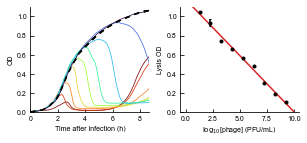

In [14]:
import xlsxwriter

# Create a workbook and add a worksheet.
workbook = xlsxwriter.Workbook("../output/Fig2a.xlsx")
writer = pd.ExcelWriter("../output/Fig2a.xlsx", engine = 'xlsxwriter')
########################################

def linear(x,k,b):
    return k*x + b

fontSize=7
matplotlib.rcParams.update({"axes.formatter.limits": (-4,4),'font.family':'Arial','font.size': fontSize, "axes.titlesize": fontSize, "xtick.labelsize": fontSize, "ytick.labelsize": fontSize,})
plotStyles={"markersize":12,"markeredgewidth":2.0,"linewidth":2.0}
stepStyles={"markersize":15,"markeredgewidth":3.0,"linewidth":4.0,"where":"post"}
scatterStyles={"linewidth":1.0}
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

phage_range = np.arange(9,0,-1); 


matplotlib.rcParams.update({"figure.figsize": (4.2,2)})
ax = plt.subplot(1,2,2)
x_data = np.array([]);
y_data = np.array([]); 

###################################
pltx_data = np.array([]);
plty_data = np.array([]); 
plty_err_data = np.array([]); 
###################################

for i in phage_range:
    phage = 2*10**i; 
    if i == 11:
        next;
    else:
        y_all = np.array([]);
        
        ######################################    
        plty_all = np.array([]);
        ######################################    
        
        for j in OD_01[i]:
            ######################################    
            plty_all = np.append(plty_all, j);
            ######################################    
            
            if i < 1:
                plt.plot(np.log10(phage), j, 'o', color='lightgray')
            else:
                y_all = np.append(y_all, j);
                x_data = np.append(x_data, np.log10(phage))
                y_data = np.append(y_data, j)
        if i == 7:    
            plt.errorbar(np.log10(phage), np.mean(y_all), yerr=np.std(y_all)/2, capsize=1, fmt='o', color='k',markersize=3,label='Experiment',zorder=15)
        else:
            plt.errorbar(np.log10(phage), np.mean(y_all), yerr=np.std(y_all)/2, capsize=1, fmt='o', color='k',markersize=3,zorder=15)
        ######################################    
        pltx_data = np.append(pltx_data, np.log10(phage))
        plty_data = np.append(plty_data, np.mean(plty_all))
        plty_err_data = np.append(plty_err_data, np.std(plty_all)/2)
        ######################################    
        

######################################            
df_tmptmp = pd.DataFrame({'log10 [PFU/mL]': pltx_data,\
                          'Lysis OD (mean)': plty_data, \
                          'Lysis OD (error)': plty_err_data}, \
                            columns=['log10 [PFU/mL]', \
                                     'Lysis OD (mean)',\
                                     'Lysis OD (error)' ])
df_tmptmp = df_tmptmp.T
df_tmptmp.to_excel(writer, sheet_name = 'right')
######################################    

popt, pcov = curve_fit(linear, x_data[:-1], y_data[:-1])
xdata = np.linspace(0, 10, 1000); 
plt.plot(xdata, linear(xdata, *popt),linewidth=1.5, color='tab:red', label='Linear fit')#, label='fit (slope = '+'{:.2f}'.format(popt[0])+'intersect='+'{:.2f}'.format(popt[1])+')')
plt.xlabel('$\log_{10}$[phage] (PFU/mL)')
plt.ylabel('Lysis OD')
plt.ylim((0,1.1))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis="y",direction="in")
ax.tick_params(axis="x",direction="in")

ax = plt.subplot(1,2,1)
x_ = df.iloc[0].to_numpy()/60

######################################    
dftmptmp = pd.DataFrame();
######################################    

for j in ['E5','E6','F5','F6']:
    y_ = df.loc[j].to_numpy() - ymean;
    if j == 'E5':
        
        ######################################    
        dftmptmp['Time (h)'] = x_[6:]/60 - x_[6]/60;
        dftmptmp['Uninfected'] = y_[6:];
        ######################################    
        
        plt.plot(x_[6:]/60 - x_[6]/60, y_[6:],'-',linewidth=1,color='k',linestyle='--', dashes=(5, 5),label='Uninfected',zorder=15)
    else:
        plt.plot(x_[6:]/60 - x_[6]/60, y_[6:],'-',linewidth=1,color='k',linestyle='--', dashes=(5, 5),zorder=15)
    
for i in phage_range:
    OD = np.array([]);
    time_ = np.array([]);
    for n in [3]:
        j = my_dict['1e'+str(i)][n];
        y_ = df.loc[j].to_numpy() - ymean;
        
        ######################################    
        phage = 2*10**i; 
        phage = "{:.1e}".format(phage)
        dftmptmp[phage] = y_[6:];
        ######################################    
        
        if j == 'C1':
            plt.plot(x_[6:]/60 - x_[6]/60, y_[6:], linewidth=0.75,color = colors[9-i,:],label='Infected')
        else:
            plt.plot(x_[6:]/60 - x_[6]/60, y_[6:], linewidth=0.75,color = colors[9-i,:]);            
            
plt.tight_layout()
plt.xlabel('Time after infection (h)')
plt.ylabel('OD')
plt.xlim((0,520/60))
plt.ylim((0,1.1))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis="y",direction="in")
ax.tick_params(axis="x",direction="in")
plt.savefig('../output/fig2a.pdf', format='pdf', bbox_inches='tight')

######################################  
dftmptmp = dftmptmp.T
dftmptmp.to_excel(writer, sheet_name = 'left') 
writer.close()